# UPRAVLJANJE NEWTONOVIM FRAKTALOM

In [1]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt

from scipy.ndimage import map_coordinates

import cmath
import math

from enum import Enum

from typing import Self, Tuple, List, Union, Callable

In [2]:
TOLERANCE = 1e-3
MAX_ITERATIONS = 50

In [3]:
class DisplayEdgeMethodEnum(Enum):
    NEIGHBOR = 1
    CIRCLE = 2

class BasinsOfAttractionColorEnum(Enum):
    DARK_INDIGO = [0.122, 0.125, 0.255]
    DEEP_PURPLE = [0.294, 0.247, 0.447]
    GOLDENROD = [1.0, 0.784, 0.341]
    TEAL = [0.067, 0.616, 0.643]
    STEEL_TEAL = [0.098, 0.392, 0.494]

In [4]:
class CoordinatePlane:
    def __init__(
        self,
        h_max: int = 800,
        x_min: float = -2,
        x_max: float = 2,
        y_min: float = -2,
        y_max: float = 2
    ):
        self._h_max = h_max
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

    def meshgrid(self) -> tuple[np.ndarray, np.ndarray]:
        v_max = int((self._h_max / (self.x_max - self.x_min)) * (self.y_max - self.y_min))
        
        x = np.linspace(self.x_min, self.x_max, self._h_max)
        y = np.linspace(self.y_max, self.y_min, v_max)
        
        return np.meshgrid(x, y)

In [5]:
class Fractal:
    def on_coordinate_plane(self, plane: CoordinatePlane) -> Self:
        self.plane = plane
        self.X, self.Y = plane.meshgrid()
        self.Z = self.X + 1j * self.Y
        
        return self

    def from_function_zeros(self, zeros: List[complex]) -> Self:
        self.f, self.df = PolynomialBuilder.create_for_function_zeros(zeros)
        self.f_zeros = zeros
        
        return self

    def from_derivate_zeros(self, zeros: List[complex], f_const: int=0, f_scale: int=1) -> Self:
        self.f, self.df = PolynomialBuilder.create_for_derivate_zeros(zeros, f_const, f_scale)
        self.f_zeros = self.f.r
        
        return self

    def from_function_expression(
        self, 
        f_expr: Union[sp.Expr, Callable[[np.ndarray], np.ndarray]]
    ) -> Self:
        self.f, self.df = PolynomialBuilder.create_for_function_expression(f_expr)
        self.f_zeros = self.f.r
        
        return self

    def display_colored(self, title: str) -> None:
        iterations = np.zeros(self.Z.shape, dtype=int)
        self._compute_newton_convergence(iterations=iterations)

        display_manager = DisplayManager(self.plane)
        display_manager.colored(title, self.Z, self.f_zeros, iterations)

    def display_edges(
        self, 
        method: DisplayEdgeMethodEnum,
        title: str, 
        radius: float=0.005, 
        circle_points: int=4
    ) -> None:
        zero_indices = np.full(self.Z.shape, -1, dtype=int)
        self._compute_newton_convergence(zero_indices=zero_indices)

        display_manager = DisplayManager(self.plane)
        display_manager.edges(
            method,
            title,
            self.X,
            self.Y,
            self.Z,
            zero_indices,
            radius,
            circle_points
        )

    def _compute_newton_convergence(
        self, 
        iterations: np.ndarray | None = None,
        zero_indices: np.ndarray | None = None
    ) -> None:
        converged = np.zeros(self.Z.shape, dtype=bool)
        
        for iteration in range(MAX_ITERATIONS):
            not_converged = ~converged
            if np.all(converged):
                break

            self.Z[not_converged] = (
                self.Z[not_converged] - self.f(self.Z[not_converged]) / self.df(self.Z[not_converged])
            )

            for index, zero in enumerate(self.f_zeros):
                mask = (np.abs(self.Z - zero) < TOLERANCE) & not_converged
                
                converged[mask] = True 
                
                if iterations is not None:
                    iterations[mask] = iteration
                if zero_indices is not None:
                    zero_indices[mask] = index

In [6]:
class DisplayManager:
    def __init__(
        self,
        plane: CoordinatePlane
    ):
        self.plane = plane

    def colored(
        self,
        title: str,
        Z: np.ndarray,
        f_zeros: np.ndarray,
        iterations: np.ndarray
    ) -> None:
        image = Colorizer.get_colored(Z, f_zeros, iterations)
        
        self._display(image, title)

    def edges(
        self,
        method: DisplayEdgeMethodEnum,
        title: str,
        X: np.ndarray,
        Y: np.ndarray,
        Z: np.ndarray,
        zero_indices: np.ndarray,
        radius: float=0.005,
        circle_points: int=4
    ) -> None:
        edge_detector = EdgeDetector(X, Y, Z, zero_indices)
        
        image = {
            DisplayEdgeMethodEnum.NEIGHBOR: lambda: edge_detector.get_edges_neighbor(),
            DisplayEdgeMethodEnum.CIRCLE: lambda: edge_detector.get_edges_circle(radius, circle_points),
        }[method]()
        
        self._display(image, title)

    def _display(self, image: np.ndarray, title: str) -> None:
        plt.figure(figsize=(8, 8))
        plt.imshow(image, cmap="binary", extent=(
            self.plane.x_min,
            self.plane.x_max,
            self.plane.y_min,
            self.plane.y_max
        ))
        plt.title(title)
        plt.xlabel("Re(z)")
        plt.ylabel("Im(z)")
        plt.grid(False)
        plt.axis("off")
        # plt.savefig("slika.png", dpi=300, bbox_inches="tight")
        plt.show()

In [7]:
class Colorizer:
    @staticmethod
    def get_colored(
        Z: np.ndarray,
        f_zeros: np.ndarray,
        iterations: np.ndarray
    ) -> np.ndarray:
        image = np.zeros(Z.shape + (3,))
        
        for index, zero in enumerate(f_zeros):
            mask = np.abs(Z - zero) < TOLERANCE
            
            color = np.array(Colorizer._get_color(index).value)
            
            normalized_iterations = iterations[mask] / MAX_ITERATIONS
            brightness = 1 - normalized_iterations[:, np.newaxis]
            
            image[mask] = color * brightness
            
        return image

    @staticmethod
    def _get_color(index: int) -> BasinsOfAttractionColorEnum:
        colors = [
            BasinsOfAttractionColorEnum.DARK_INDIGO,
            BasinsOfAttractionColorEnum.DEEP_PURPLE,
            BasinsOfAttractionColorEnum.GOLDENROD,
            BasinsOfAttractionColorEnum.TEAL,
            BasinsOfAttractionColorEnum.STEEL_TEAL,
        ]
        
        return colors[index % len(colors)]

In [8]:
class EdgeDetector:
    def __init__(
        self,
        X: np.ndarray,
        Y: np.ndarray,
        Z: np.ndarray,
        zero_indices: np.ndarray
    ):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.zero_indices = zero_indices

    def get_edges_neighbor(self) -> np.ndarray:
        indices_arr = self.zero_indices
        padded_indices_arr = np.pad(indices_arr, pad_width=1, constant_values=-1)
        
        mask = np.zeros(padded_indices_arr.shape, dtype=bool)

        # svi susjedni smjerovi: gore, dolje, lijevo, desno
        for shift, axis in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            shifted = np.roll(padded_indices_arr, shift=shift, axis=axis)
            diff = (shifted != padded_indices_arr)\
                & (padded_indices_arr != -1)\
                & (shifted != -1)
            mask |= diff

        # maska bez paddinga
        return mask[1:-1, 1:-1]

    def get_edges_circle(
        self,
        radius: float=0.005,
        circle_points: int=4
    ) -> np.ndarray:
        offsets = self._get_circle_subpixel_offsets(radius, circle_points)
        mask = np.zeros(self.Z.shape, dtype=bool)

        indices_y, indices_x = np.meshgrid(
            np.arange(self.Z.shape[0]),
            np.arange(self.Z.shape[1]),
            indexing='ij'
        )

        for vertical, horizontal in offsets:
            shifted_indices_y = indices_y - vertical
            shifted_indices_x = indices_x - horizontal
    
            shifted = map_coordinates(
                self.zero_indices.astype(float),
                [shifted_indices_y, shifted_indices_x],
                order=1,
                mode='constant',
                cval=-1
            )
            
            diff = (shifted != self.zero_indices) & (self.zero_indices != -1) & (shifted != -1) 
            mask |= diff
    
        return mask

    def _get_circle_subpixel_offsets(
        self,
        radius: float,
        points: int
    ) -> List[Tuple[float, float]]:
        spacing_x = self.X[0, 1] - self.X[0, 0]
        spacing_y = self.Y[1, 0] - self.Y[0, 0]

        # Euler
        point_on_unit_circle = lambda k, n: np.exp(2j * np.pi * k / n)
    
        for k in range(points):
            complex_point = radius * point_on_unit_circle(k, points)
            
            offset_x = np.real(complex_point) / spacing_x
            offset_y = np.imag(complex_point) / spacing_y
            
            yield (offset_y, offset_x)

In [9]:
class PolynomialBuilder:
    @staticmethod
    def create_for_function_zeros(
        zeros: List[complex]
    ) -> Tuple[np.poly1d, np.poly1d]:
        poly_coeffs = np.poly(zeros)
        dpoly_coeffs = np.polyder(poly_coeffs)
        
        return np.poly1d(poly_coeffs), np.poly1d(dpoly_coeffs)

    @staticmethod
    def create_for_derivate_zeros(
        zeros: List[complex],
        f_const: int=0,
        f_scale: int=1,
    ) -> Tuple[np.poly1d, np.poly1d]:
        dpoly_coeffs = f_scale * np.poly(zeros)
        poly_coeffs = np.polyint(dpoly_coeffs, k=f_const)
        
        return np.poly1d(poly_coeffs), np.poly1d(dpoly_coeffs)

    @staticmethod
    def create_for_function_expression(
        f_expr: Union[sp.Expr, Callable[[np.ndarray], np.ndarray]]
    ) -> Tuple[np.poly1d, np.poly1d]:
        z = sp.Symbol('z')
        poly = sp.Poly(f_expr, z)

        poly_coeffs = list(map(float, poly.all_coeffs()))
        dpoly_coeffs = np.polyder(poly_coeffs)

        return np.poly1d(poly_coeffs), np.poly1d(dpoly_coeffs)

# GALERIJA

In [10]:
coordinate_plane = CoordinatePlane()

z = sp.Symbol('z')
f3_expr = z**3 - 1
f5_expr = z**5 - 1

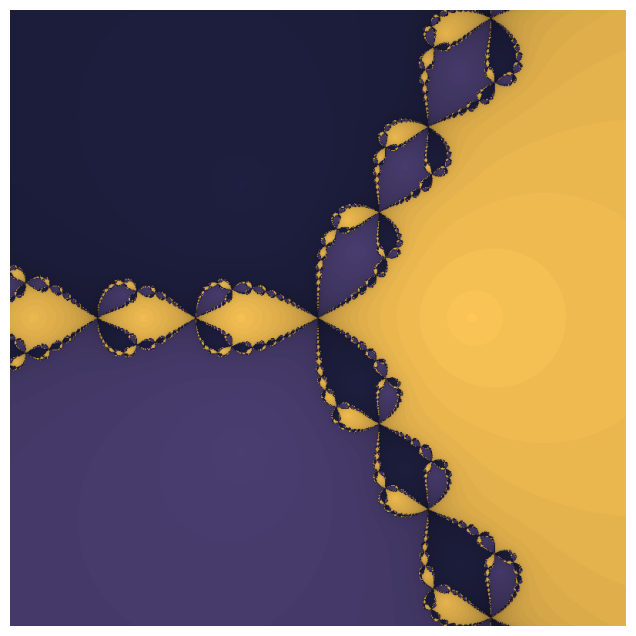

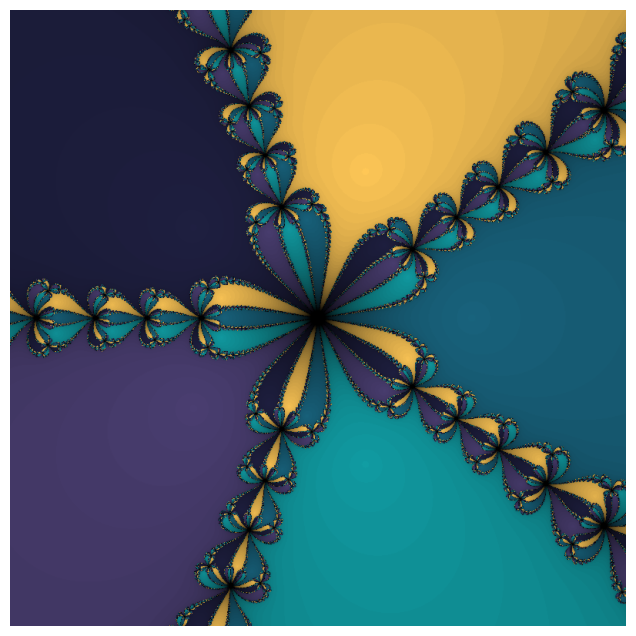

In [11]:
# Hipoteza 1

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_function_expression(f3_expr)\
    .display_colored("")

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_function_expression(f5_expr)\
    .display_colored("")

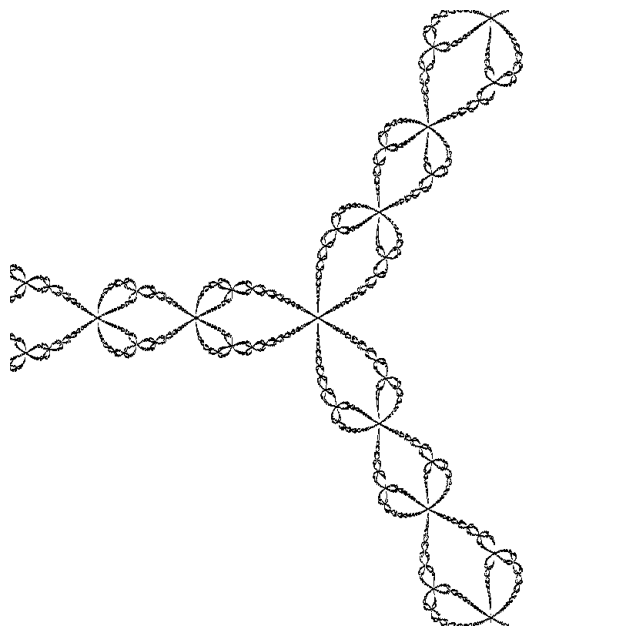

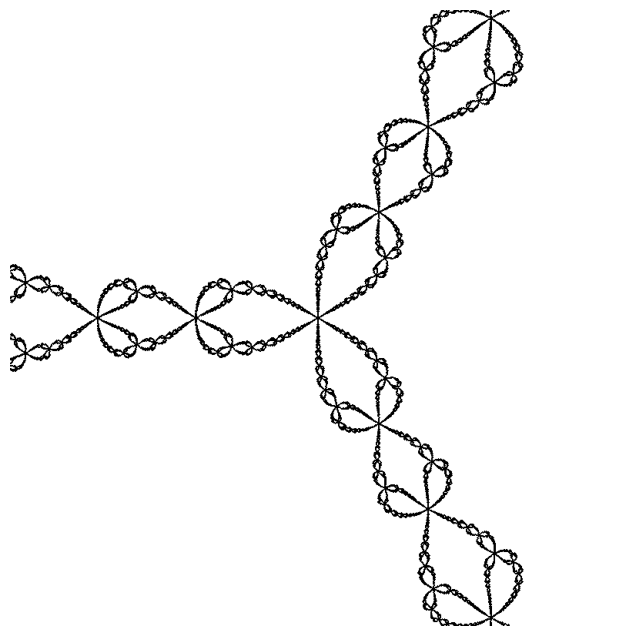

In [12]:
# Hipoteza 2

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_function_expression(f3_expr)\
    .display_edges(DisplayEdgeMethodEnum.NEIGHBOR, "")

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_function_expression(f3_expr)\
    .display_edges(DisplayEdgeMethodEnum.CIRCLE,
                   "",
                   radius=0.0005,
                   circle_points=4)

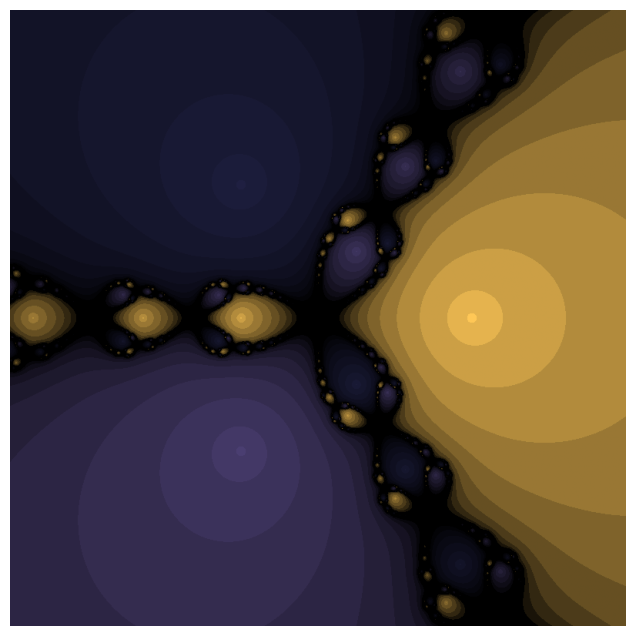

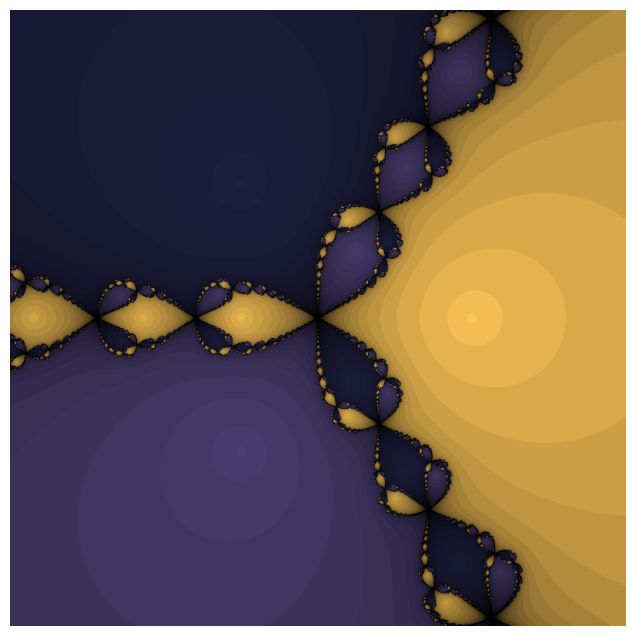

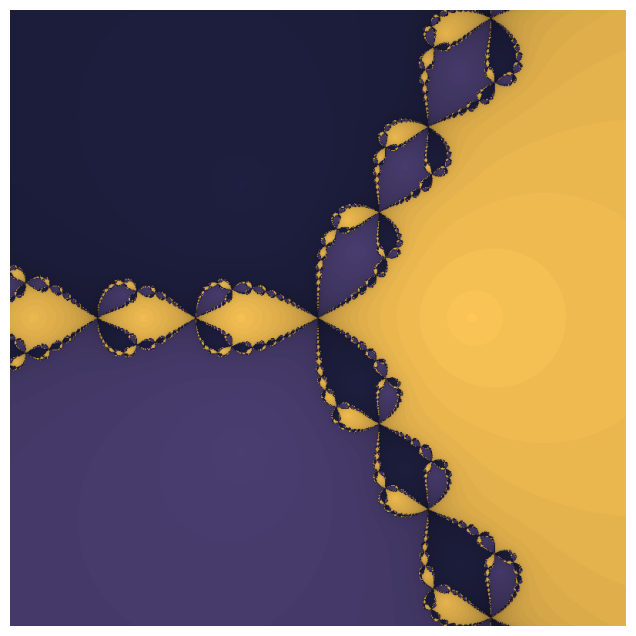

In [13]:
# Hipoteza 3

MAX_ITERATIONS = 10

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_function_expression(f3_expr)\
    .display_colored("")

MAX_ITERATIONS = 20

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_function_expression(f3_expr)\
    .display_colored("")

MAX_ITERATIONS = 50

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_function_expression(f3_expr)\
    .display_colored("")

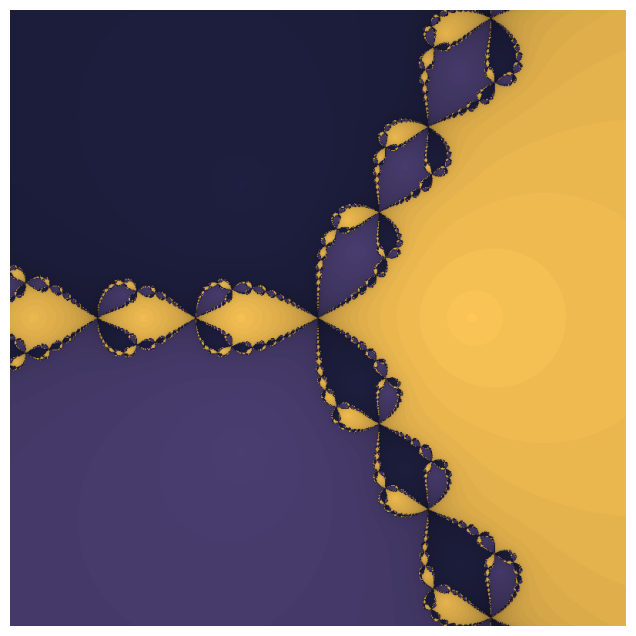

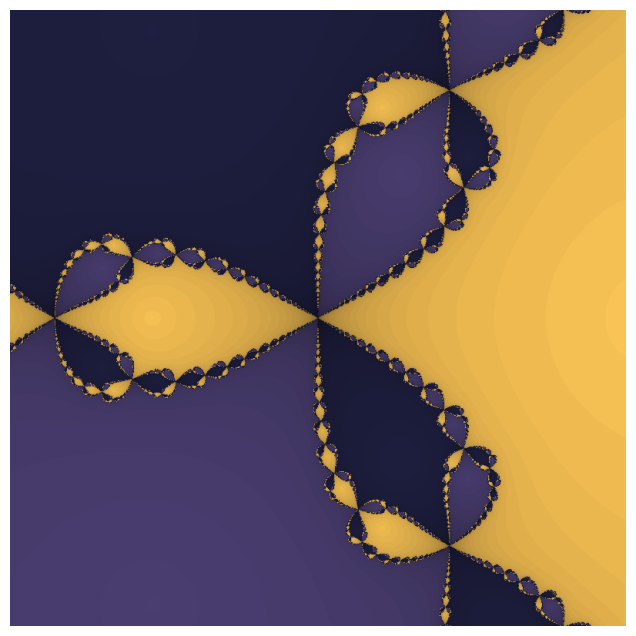

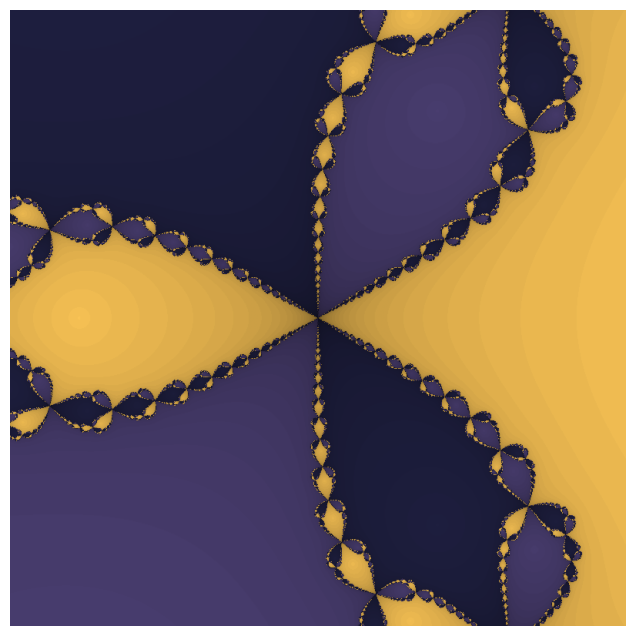

In [14]:
# Hipoteza 4

df_zeros = [(0+0j), (0+0j)]

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_derivate_zeros(df_zeros, -1, 3)\
    .display_colored("")

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_derivate_zeros(df_zeros, -10, 3)\
    .display_colored("")

Fractal()\
    .on_coordinate_plane(coordinate_plane)\
    .from_derivate_zeros(df_zeros, -30, 3)\
    .display_colored("")